In [409]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import re
import math
from pathlib import Path
import pysrt
from difflib import get_close_matches
import re
import fitz
import nltk
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
import string
from string import digits
import textstat
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /Users/a.babaev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/a.babaev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/a.babaev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/a.babaev/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/a.babaev/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [410]:
HTML = r'<.*?>'
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Z ]+[\)\]]'
LETTERS = r'[^a-zA-Z\'.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'
HYPHENS = r'-(?=\w)'

def clean_subs(subs):
    txt = ".".join(subs.lower().split('.')[1:-1]) #удаляем первый и последний субтитр (обычно это реклама)
    txt = re.sub(HTML, ' ', subs) #html тэги меняем на пробел
    txt = re.sub(TAG, ' ', txt) #тэги меняем на пробел
    txt = re.sub(COMMENTS, ' ', txt) #комменты меняем на пробел
    txt = re.sub(LETTERS, ' ', txt) #все что не буквы меняем на пробел
    txt = re.sub(SPACES, r'\1', txt) #повторяющиеся пробелы меняем на один пробел
    txt = re.sub(DOTS, r'.', txt)  #многоточие меняем на точку
    txt = re.sub(HYPHENS, '', txt)  #убирем дефисы
    txt = txt.encode('ascii', 'ignore').decode() #удаляем все что не ascii символы
    return txt.lower()

In [411]:
# загрузим файл с названием фильмов
titles = pd.read_excel('/Users/a.babaev/Documents/datasets/English_scores/movies_labels.xlsx')
titles = titles.drop_duplicates(subset='Movie', keep='first')

In [412]:
# создадим список с адресами файлов с субтитрами
paths = list(Path('/Users/a.babaev/Documents/datasets/English_scores').rglob('*.srt'))

In [413]:
# создадим датафрейм с названием фильма и его сложностью
movies = pd.DataFrame({'title': [x.name for x in paths],
                       'level': [x.parent.name for x in paths],
                       'path':  [x for x in paths]})

In [414]:
# уберем расширение из названия файла
movies['title'] = movies['title'].str.replace('.srt', '')

In [415]:
# используем поиск по неполному соотвествию с датафреймом 'titles'
movies['Movie'] = movies['title'].map(lambda x: get_close_matches(x, titles['Movie'], n=1, cutoff=0.8)[0:1])

In [416]:
# приведем данные к строке
movies['Movie'] = movies['Movie'].str.join(', ')

# объединим датафреймы
movies = movies.merge(titles[['Movie', 'Level']], how='left', on='Movie')

# для фильмов, находящихся в папке 'Subtitles', используем оценки из датафрейма 'titles'
movies.loc[(movies['level'] == 'Subtitles'), 'level'] = movies.loc[(movies['level'] == 'Subtitles'), 'Level']

# удалим ненужные данные
movies = movies.drop(['Movie', 'Level'], axis=1)

In [417]:
# иучим распределение фильмов по уровню сложности
movies['level'].value_counts()

B2            136
B1             51
C1             39
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      4
Name: level, dtype: int64

In [418]:
# сгруппируем уровни сложности
movies.loc[(movies['level'] == 'A2/A2+'), 'level'] = 'A2'
movies.loc[(movies['level'] == 'A2/A2+, B1'), 'level'] = 'A2'
movies.loc[(movies['level'] == 'B1, B2'), 'level'] = 'B1'

In [419]:
# объединим pdf-словари в один файл
pdf_path_list = list(Path('/Users/a.babaev/Documents/datasets/').rglob('*.pdf'))
out_pdf_path = "/Users/a.babaev/Documents/datasets/merged_dictionary.pdf"
doc = fitz.Document()

for i in range(len(pdf_path_list)):
    sub_doc = fitz.open(pdf_path_list[i])
    doc.insert_pdf(sub_doc)

In [420]:
# извлечем данные из pdf-файла
out = open("/Users/a.babaev/Documents/datasets/text_dictionary.txt", "wb")
for page in doc: 
    text = page.get_text('html').encode("utf8")
    out.write(text)
out.close()

In [421]:
# распарсим данные из html-разметки
with open('/Users/a.babaev/Documents/datasets/text_dictionary.txt') as f:
    soup = BeautifulSoup(f.read(), 'lxml')

word = []
part = []
rows = soup.find_all('p',class_=None)

for i in range(len(rows)):
    word.append(rows[i].find_all('span', class_=None)[0].text)
    
    try:
        part.append(rows[i].find_all('span', class_=None)[4].text)
    except:
        pass
        try:
            part.append(rows[i].find_all('span', class_=None)[3].text)  
        except:
            pass
            try:
                part.append(rows[i].find_all('span', class_=None)[2].text)  
            except:
                pass
                try:
                    part.append(rows[i].find_all('span', class_=None)[1].text)  
                except:
                    part.append('')

dictionary = pd.DataFrame({'word':word, 'part':part})

In [422]:
# присвоим словам уровень сложности
level_index = dictionary[dictionary['word'].str.contains('^[A-C][1-2]')].index
dictionary.loc[dictionary['word'].str.contains('^[A-C][1-2]'), 'level'] = dictionary.loc[dictionary['word'].str.contains('^[A-C][1-2]'), 'word']
dictionary['level'] = dictionary['level'].fillna(method='ffill')
dictionary = dictionary.drop(index=level_index)

In [423]:
# удалим лишние строки
dictionary = dictionary.drop(dictionary.loc[dictionary['word'].str.contains('™|©|/', na=False)].index)
dictionary = dictionary.drop(dictionary.loc[dictionary['part'].str.contains('level', na=False)].index)
dictionary['word'] = dictionary['word'].str.strip()

In [424]:
# обработаем полученные данные
remove_digits = str.maketrans('', '', digits)
dictionary['word'] = dictionary['word'].str.translate(remove_digits)
dictionary['part'] = dictionary['part'].str.split('.',expand=True)[0]
dictionary['part'] = dictionary['part'].str.split(',',expand=True)[0]
dictionary['part'] = dictionary['part'].str.split('/',expand=True)[0]
dictionary.loc[(dictionary['part'] == 'noun'), 'part'] = 'n'
dictionary['part'] = dictionary['part'].str.strip()
dictionary = dictionary[dictionary['word'] != '']
dictionary = dictionary.dropna(subset='level')
dictionary = dictionary.drop_duplicates(subset=['word', 'level'])
dictionary = dictionary.drop_duplicates(subset=['word'], keep='first').reset_index(drop=True)

In [425]:
dictionary.head()

,word,part,level
0,"a, an",indefinite article,A1
1,about,prep,A1
2,above,prep,A1
3,across,prep,A1
4,action,n,A1


In [426]:
dictionary.groupby('level')[['word']].count()

,word
level,
A1,919
A2,818
B1,706
B2,1314
C1,1316


In [427]:
# токенизируем слова из файлов с субтитрами, а затем лемматизируем их
stops = set(stopwords.words("english") + list(string.punctuation))
tag_map = defaultdict(lambda : wn.NOUN)
lemma_function = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
token_list = []
lemma_list = []
movies_list = []

for i in tqdm(range(movies.shape[0]), position=1, desc='films', leave=True):
    try:
        subs = pysrt.open(movies['path'][i]).text
    except:
        subs = pysrt.open(movies['path'][i], encoding='unicode_escape').text
        
    cleaned_subs = clean_subs(subs)
    words = tokenizer.tokenize(cleaned_subs)
    meaningful_words = [w for w in words if not w in stops]
    
    for token, tag in pos_tag(meaningful_words):
        lemma = lemma_function.lemmatize(token, tag_map[tag[0]])
        token_list += [token]
        lemma_list += [lemma]
        movies_list += [movies['title'][i]]
    print(movies['title'][i], end='\r')

films:   0%|          | 0/278 [00:00<?, ?it/s]

In [428]:
# сохраним данные в датафрейм
df = pd.DataFrame({'title':movies_list,
                   'lemma':lemma_list})
df = df.drop_duplicates(subset=['title', 'lemma']).reset_index(drop=True)
df = df.merge(dictionary, how='left', left_on='lemma', right_on='word')
df = df.drop('word', axis=1)
df = df.fillna('undef')
df.loc[(df['part'] == ''), 'part'] = 'undef'
df.head()

,title,lemma,part,level
0,"Crown, The S01E01 - Wolferton Splash.en",seek,v,B2
1,"Crown, The S01E01 - Wolferton Splash.en",british,undef,undef
2,"Crown, The S01E01 - Wolferton Splash.en",nationalization,undef,undef
3,"Crown, The S01E01 - Wolferton Splash.en",royal,adj,B1
4,"Crown, The S01E01 - Wolferton Splash.en",highness,undef,undef


In [429]:
# расчитаем статистику по фильмам
levels = df.pivot_table(index=['title'], columns=['level'], aggfunc={'level':'count'})
levels_share = levels.div(levels.sum(axis=1), axis=0)

levels = levels.reset_index()
levels.columns = ['_'.join(col) for col in levels.columns]
levels = levels.rename(columns={'title_':'title'})

parts = df.pivot_table(index=['title'], columns=['part'], aggfunc={'part':'count'})
parts_share = parts.div(parts.sum(axis=1), axis=0)

report = levels_share.join(parts_share)
report = report.reset_index()

report.columns = ['_'.join(col) + '_share' for col in report.columns]
report = report.merge(movies[['title', 'level']].rename(columns={'level':'movie_difficulty'}), how='left', left_on='title__share', right_on='title')
report = report.drop('title', axis=1)
report = report.rename(columns={'title__share':'title'})
report = levels.merge(report, how='left', on='title')
report.head()

,title,level_A1,level_A2,level_B1,level_B2,level_C1,level_undef,level_A1_share,level_A2_share,level_B1_share,...,part_det_share,part_exclam_share,part_modal v_share,part_n_share,part_number_share,part_prep_share,part_pron_share,part_undef_share,part_v_share,movie_difficulty
0,10_Cloverfield_lane(2016),301.0,143.0,81.0,62.0,29.0,191.0,0.372986,0.177200,0.100372,...,0.012392,0.009913,0.004957,0.322181,0.008674,0.012392,0.011152,0.237918,0.209418,B1
1,10_things_I_hate_about_you(1999),375.0,186.0,111.0,115.0,62.0,458.0,0.286917,0.142311,0.084927,...,0.007651,0.007651,0.004591,0.275440,0.007651,0.008416,0.009946,0.354246,0.170620,B1
2,A_knights_tale(2001),354.0,182.0,100.0,98.0,62.0,405.0,0.294754,0.151540,0.083264,...,0.009992,0.007494,0.005828,0.269775,0.014988,0.012490,0.009159,0.339717,0.185679,B2
3,A_star_is_born(2018),384.0,199.0,81.0,79.0,36.0,286.0,0.360563,0.186854,0.076056,...,0.011268,0.012207,0.003756,0.331455,0.006573,0.011268,0.012207,0.269484,0.184977,B2
4,Aladdin(1992),340.0,185.0,99.0,109.0,55.0,450.0,0.274637,0.149435,0.079968,...,0.009693,0.010501,0.006462,0.261712,0.006462,0.007270,0.008885,0.364297,0.159128,A2


In [430]:
# расчитаем дополнительную статистику по фильмам
movies_list = []
syllable = []
lexicon = []
sentence = []
char = []
letter = []
polysyllab = []
monosyllab = []

for i in tqdm(range(movies.shape[0]), position=1, desc='films', leave=True):
    try:
        subs = pysrt.open(movies['path'][i]).text
    except:
        subs = pysrt.open(movies['path'][i], encoding='unicode_escape').text
        
    cleaned_subs = clean_subs(subs)
    movies_list += [movies['title'][i]]

    syllable.append(textstat.syllable_count(cleaned_subs)) # Syllable Count
    lexicon.append(textstat.lexicon_count(cleaned_subs, removepunct=True)) # Lexicon Count
    sentence.append(textstat.sentence_count(cleaned_subs)) # Sentence Count
    char.append(textstat.char_count(cleaned_subs, ignore_spaces=True)) # Character Count
    letter.append(textstat.letter_count(cleaned_subs, ignore_spaces=True)) # Letter Count
    polysyllab.append(textstat.polysyllabcount(cleaned_subs)) # Polysyllable Count
    monosyllab.append(textstat.monosyllabcount(cleaned_subs)) # Monosyllable Count            
    print(movies['title'][i], end='\r')

films:   0%|          | 0/278 [00:00<?, ?it/s]

In [431]:
# сохраним данные в датафрейм
df_stat = pd.DataFrame({'title':movies_list,
                        'syllable':syllable,
                        'lexicon':lexicon,
                        'sentence':sentence,
                        'char':char,
                        'letter':letter,
                        'polysyllab':polysyllab,
                        'monosyllab':monosyllab
                       })

In [432]:
# объединим данные со статистикой в один датафрейм
report = report.merge(df_stat, how='left', on='title')

In [433]:
# заполним пропуски в данных
imputer = KNNImputer(n_neighbors=5)
columns = ['level_A1', 'level_A2', 'level_B1', 'level_B2', 'level_C1',
           'level_undef', 'level_A1_share', 'level_A2_share', 'level_B1_share',
           'level_B2_share', 'level_C1_share', 'level_undef_share',
           'part_adj_share', 'part_adv_share', 'part_conj_share', 'part_det_share',
           'part_exclam_share', 'part_modal v_share', 'part_n_share',
           'part_number_share', 'part_prep_share', 'part_pron_share',
           'part_undef_share', 'part_v_share']

before_imputation = report[columns]
after_imputation = imputer.fit_transform(before_imputation)
report[columns] = after_imputation

In [434]:
# стандартизируем данные
numeric = report.select_dtypes(include='float64').columns.to_list()

# создадим объект класса StandardScaler:
scaler = StandardScaler()
#scaler = MinMaxScaler()

# обучаем scaler:
scaler.fit(report[numeric]) 

# применяем стандартизацию к матрице признаков:
report[numeric] = scaler.transform(report[numeric])

In [435]:
# закодируем целевую переменную
report = report.dropna(subset='movie_difficulty')
encoder = OrdinalEncoder() 
report['movie_difficulty'] = encoder.fit_transform(report[['movie_difficulty']])

In [436]:
report = report[['title', 'level_A1_share', 'level_A2_share', 'level_B1_share',
           'level_B2_share', 'level_C1_share', 'level_undef_share',
           'part_adj_share', 'part_adv_share', 'part_conj_share', 'part_det_share',
           'part_exclam_share', 'part_modal v_share', 'part_n_share',
           'part_number_share', 'part_prep_share', 'part_pron_share',
           'part_undef_share', 'part_v_share', 'movie_difficulty']]

In [437]:
# # разделим выборки на матрицу признаков X и вектор целевой переменной y:
X = report.drop(['title', 'movie_difficulty'], axis=1)
y = report['movie_difficulty']

# разделим данные на обучающую выборку и остальной датасет:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

In [438]:
# зададим гиперпараметры для модели:
n_estimators = np.arange(10, 110, 10)
max_depth = np.arange(1, 11, 1)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

# обучим модель:
gbr = GradientBoostingClassifier(random_state=42, loss='log_loss')

model = RandomizedSearchCV(estimator=gbr, 
                           param_distributions=random_grid,
                           n_iter = 10, 
                           cv = ShuffleSplit(test_size=0.20, n_splits=5, random_state=42), 
                           verbose=1,
                           return_train_score=True,
                           random_state=42, 
                           n_jobs = -1)

model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.2, train_size=None),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
                   random_state=42, return_train_score=True, verbose=1)

In [439]:
# проверим модель на тестовой выборке
y_pred = model.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, y_pred, normalize=True))

accuracy_score: 0.5370370370370371


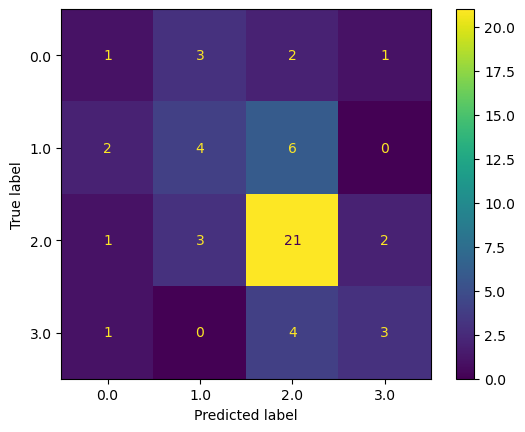

In [440]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)